# Laboratorium 2: DataLoadery i prosta sieć CNN (MedMNIST – PneumoniaMNIST)
 
**Cel:** nauczyć się przygotowywania **własnego Datasetu** w PyTorch oraz wykorzystać go do **szybkiego treningu prostej sieci CNN** na małym, medycznym zbiorze danych.


> **Dataset:** użyjemy **PneumoniaMNIST** z kolekcji **MedMNIST** – to mały, 2-klasowy zbiór obrazów RTG płuc (zapalenie płuc vs brak). Dataset zostanie **automatycznie pobrany** w notebooku. Użyty zostanie też dataset **OrganMNIST3D** do klasyfikacji organów na podstawie danych trójwymiarowych.

## 0) Instalacja i importy

In [37]:
# !pip -q install medmnist torchmetrics tqdm --extra-index-url https://download.pytorch.org/whl/cpu

import os, sys, time, json, math, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from tqdm.auto import tqdm
from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix

import medmnist
from medmnist import PneumoniaMNIST
from medmnist import INFO

import PIL.Image as Image
 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print("PyTorch:", torch.__version__)

PyTorch: 2.7.1+cu128


## 1) Pobranie i eksploracja danych (MedMNIST – PneumoniaMNIST)

Skrypt automatycznie pobiera zbiór **PneumoniaMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru.

Opis: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
Liczba klas: 2 ; klasy: {'0': 'normal', '1': 'pneumonia'}
Rozmiar obrazów: (28, 28)
Rozmiary: 4708 524 624


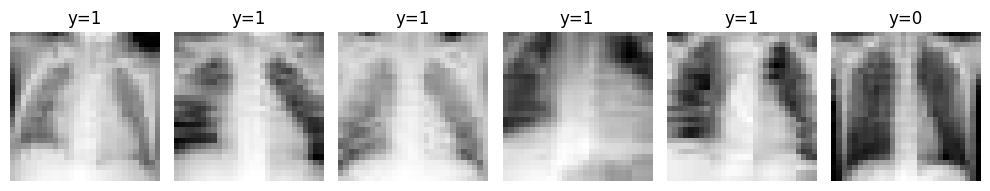

In [38]:
DATA_ROOT = "./data/medmnist"
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pneumoniamnist']
print("Opis:", info['description'])
print("Liczba klas:", len(info['label']), "; klasy:", info['label'])

# Print image shape using the first image in the train set
sample_img, _ = PneumoniaMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=False)[0]
print("Rozmiar obrazów:", np.array(sample_img).shape)

train_set_raw = PneumoniaMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=False)
val_set_raw   = PneumoniaMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=False)
test_set_raw  = PneumoniaMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=False)

print("Rozmiary:", len(train_set_raw), len(val_set_raw), len(test_set_raw))

fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, label = train_set_raw[i]
    img_np = np.array(img)
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f"y={int(label.squeeze().item())}")
    axes[i].axis('off')
plt.tight_layout(); plt.show()

## Zadanie 1 – Własny `Dataset` i `DataLoader`

W pierwszym kroku chcemy przygotować własny Datasoader dla zbioru PneumoniaMNIST. Dla popularnych zbiorów danych zazwyczaj nie ma konieczności pisania własnego Datasetu, ale dobrze jest wiedzieć jak powinien on działać.
Dataset jest klasą dziedziczącą po klasie `Dataset` z `torch.utils.data`, która pozwala na wczytywanie danych. Musi ona zawierać przynajmniej 3 metody: `__init__` - stworzenie i inicjalizacja obiektów klasy, `__len__` - sprawdzenie liczby dostępnych próbek, `__getitem__` - pobranie próbki o zadanym indeksie. Zazwyczaj Dataset odpowiedzialny jest również za transformacje i augmentację danych, ale tym będziemy zajmować się później.
W naszym przypadku zbiór danych jest bardzo mały, więc możemy cały trzymać w pamięci, ale zazwyczaj dane są przechowywane na dysku i odczytywane dopiero wtedy, kiedy musimy je przetworzyć (czyli stosujemy lazy loading).

1. Zaimplementuj klasę `PneumoniaCustomDataset`, która dziedziczy po klasie `Dataset`.
2. Zaimplementuj metodę `__init__`, której argumentami jest zbiór obrazów oraz zbiór odpowiadających im etykiet. Powinny one zostać zapamiętane jak pola obiektu. Dla etykiet wywołaj dodatkowo metodę `.squeeze()`.
3. Zaimplementuj metodę `__len__`, która sprawdza liczbę zapamiętanych podczas inicjalizacji obrazów.
4. Zaimplementuj metodę `__getitem__`, której argumentem jest indeks pobieranej próbki. W tym miejscu powinniśmy zapewnić, że zwracane próbki są oczekiwanego typu i rozmiaru.
5. Zacznij od pobrania obrazu i etykiety o zadanym indeksie.
6. Następnie wykonaj konwersję obrazu do tensora za pomocą `transforms.ToTensor()(x)`.
7. Wykonaj konwersję etykiet do tensora za pomocą `torch.tensot`. Docelowym typem danych powinien być `torch.long`.
8. Zwróć próbkę danych oraz etykietę.
9. Poza klasą stwórz 3 datasety: treningowy, walidacyjny i testowy. Dane oraz etykiety można pobrać z wcześniejszych danych, np. `train_set_raw.imgs` lub `train_set_raw.labels`.
10. Wyświetl ile elementów zawiera każdy z nich.

In [39]:
# --- Zadanie 1

class PneumoniaCustomDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.labels = label  # nie squeeze()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        label = label.view(-1)  

        return torch.tensor(img, dtype=torch.float32).unsqueeze(0), label.squeeze()

    
train_dataset = PneumoniaCustomDataset(train_set_raw.imgs, train_set_raw.labels)
test_dataset = PneumoniaCustomDataset(test_set_raw.imgs, test_set_raw.labels)
val_dataset = PneumoniaCustomDataset(val_set_raw.imgs, val_set_raw.labels)

## Zadanie 2 –  DataLoadery: batching, shuffle, num_workers

Z kolei celem DataLoaderu jest wydajne dostarczanie batchy danych do treningu. Nie dostarcza on pojedynczych próbek, lecz cały ich zbiór nazywany batchem. Zajmuje sie również mieszaniem danych, żeby nie były przekazywane w tej samej kolejności, pozwala na rónoległe wczytywanie danych i zwraca iterator, dzięki czemu łatwo jest przejść po wszystkich próbkach danych. Do stworzenia DataLoadera wykorzystuje się gotową klasę `DataLoader`. Nie trzeba jej implementować samodzielnie.

1. Zacznij od zdefiniowania rozmiaru batchów `BATCH_SIZE` i liczby workerów `NUM_WORKERS`.
2. Stwórz 3 DataLoadery - odpowiednio treningowy, walidacyjny i testowy. Pierwszym argumentem powinien być obiekt Dataset wykorzystywany do wczytania danych. Oprócz tego przekazujemy `batch_size`, `shuffle` (wartość boolean), `num_workers` i `pin_memory` (wartość boolean). Mieszania danych (shuffle) używa się tylko dla danych treningowych. `pin_memory` pozwala na szybsze kopiowanie danych w przypadku uczenia na GPU i wtedy warto ustawić `True`.
3. Stwórz pętlę przechodzącą po danych treningowych. Pamiętej, że DataLoader zwrócił iterator. Sprawdź rozmiar pojenynczego zestawu treningowego.

/tmp/ipykernel_5193/2217057973.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  plt.imshow(np.array(next(iter(train_dataloader))[0][0]).transpose(1, 2, 0), cmap='gray')


Text(0.5, 1.0, 'tensor(1)')

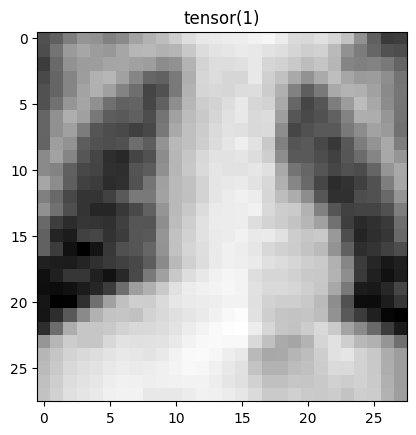

In [40]:
# --- Zadanie 2

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)

plt.imshow(np.array(next(iter(train_dataloader))[0][0]).transpose(1, 2, 0), cmap='gray')
plt.title(next(iter(train_dataloader))[1][0])

## Zadanie 3 – Prosta sieć CNN

Teraz zaimplementujemy prostą sieć konwolucyjną, której celem będzie klasyfikacja pacjentów na podstawie zdjęć jako zdrowi lub chorzy.
1. Zaimplementuj klasę `SimpleCNN`, która dziedziczy po klasie `nn.Module`. Taka klasa musi posiadać przynajmniej dwie metody: `__init__`, gdzie zdefiniowane są warstwy i parametry sieci, oraz `forward`, która określa jak dane przepływają przez sieć.
2. Stwórz metodę `__init__`, która będzie zawierać dwie warstwy konwolucyjne `nn.Conv2d`, warstwę MaxPool `nn.MaxPool2d` i dwie warstwy liniowe `nn.Linear`. Wybierz rozmiar warstw konwolucyjnych oraz dobierz padding tak, aby rozmiar wyjściowy był taki sam jak wejściowy. Wybierz również liczbę kanałów wyjściowych z tych warstw.
3. Dodaj warstwę pooling, tak, żeby zmniejszyła rozmiar o połowę.
4. Stwórz dwie warstwy w pełni połączone. Rozmiar wejścia pierwszej z nich powinien być równy rozmiarowi pomnożonemu przez liczbę kanałów. Dobierz liczbę kanałów na wyjściu. Ostatnia warstwa powinna mieć na wyjściu tylko dwa kanały.
5. Zaimplementuj metodę `forward`, której arguemntem jest próbka do przetworzenia. Wejście najpierw wchodzi na pierwszą warstwę konwolucyjną, później idzie do funkcji aktywacji ReLU `F.relu`, a dalej do warstwy poolingowej.
Następnie te same operacje wykonujemy dla drugiej warstwy konwolucyjnej. Dalej spłaszczamy dane przed podaniem ich do warstwy w pełni połączonej `torch.flatten` (drugim argumentem powinno być `1`, żeby nie usunąć wymiaru batch). Po pierwszej z tych warstw wykorzystujemy funkcję aktywacji ReLU, a następnie podajnemy na drugą z tych warstw i zwracamy jej wynik.
6. Cały schemat wygląda następująco: (1, 28, 28) --> Conv2d --> ReLU--> MaxPool2d(2x2) --> Conv2d --> ReLU --> MaxPool2d(2x2) --> Flatten --> Linear --> ReLU --> Linear --> logits.
7. Poza klasą wybierz urządzenie na którym sieć ma być uruchomiona: `device = 'cuda' if torch.cuda.is_available() else 'cpu'`.
8. Stwórz instancję sieci i załaduj ją do wybranego urządzenia za pomocą metody `.to`
9. Zdefiniuj funkcję straty jako `nn.CrossEntropyLoss()` i optymalizator jako `torch.optim.Adam`. Pierwszym argumentem optymalizatora są parametry sieci `.parameters()`, a drugim `lr`, czyli learning rate, określający jak szybko parametry modelu mają się zmieniać.
10. Wypisz warstwy modelu za pomocą `print`.

In [41]:
# --- Zadanie 3

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(32 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
    
device = "cuda" if torch.cuda.is_available() else 'cpu'

model = SimpleCNN().to(device)

# from torchvision import models
# model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.clf = nn.Linear(model.fc.in_features, 2)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

## Zadanie 4 – Trening

Teraz konieczne jest przeprowadzenie treningu zdefiniowanego modelu.

1. Zaimplementuj funkcję `run_epoch`, której zadaniem będzie wykonanie pojedynczej epoki treningu. Epoka to jedno pełne przejście modelu przez cały zbiór treningowy. Jej argumentami są: model sieci, DataLoader, optymalizator i urządzenie na którym sieć jest uruchomiona. Zakłądamy, że optymalizator jest przekazywany tylko w przypadku treningu, natomiast podczas ewaluacji wynosi `None`.
2. Na początku funkcji sprawdź czy optymalizator nie jest `None`, a więc czy sieć powinna być uczona w tym wywołaniu funkcji.
3. Jeśli ma być uczona, to ustaw ją w tryb treningu za pomocą metody `.train`. Jako argument podaj wynik wcześniejszego sprawdzenia.
4. Zainicjalizuj `lossTotal`, `correctTotal` i `total` jako 0.0.
5. Napisz pętlę, która przetwarza wszystkie dane z przekazanego DataLoadera.
6. Prześlij dane do urządzenia za pomocą metody `.to`.
7. Jeśli sieć ma być trenowana, to wyzeruj gradienty w optymalizatorze metodą `.zero_grad()`.
8. Oblicz wyjście sieci dla danego wejścia.
9. Olicz stratę dla przetworzonych danych za pomocą wybranej funkcji straty. Pierwszym argumentem jest wyście sieci, a drugim rzeczywiste etykiety.
10. Jeśli sieć ma być uczona, to oblicz gradienty funkcji straty względem parametrów sieci i wykonaj krok optymalizatora. W tym celu wywołaj metodę `.backward()` obliczonej straty,a  następnie wywołaj metodę `.step()` optymalizatora.
11. Dodaj obliczoną stratę do `lossTotal`.
12. Sprawdź predykcje sieci dla przetworzonych danych. W tym celu wykorzystaj metodę `.argmax` względem wymiaru odpowiedzialnego za batch (jest on argumentem metody).
13. Sprawdź ile predykcji było poprawnych. Porównaj wynik z poprzedniego punktu z etykietami, a następnie zsumuj wyniki porównania. Następnie skonwertuj wynikowy tensor na liczbę za pomocą metody `.item()` i dodaj wynik do `correctTotal`.
14. Zaktualizuj liczbę wszystkich przetworzonych próbek `total`.
15. Zwróć 'lossTotal' i 'correctTotal' podzielone przez liczbę przetworzonych próbek.
16. Poza definicją funkcji zdefiniuj liczbę epok treningu. W naszym prostym przypadku powinny wystarczyć 2.
17. Zaimplementuj pętlę, która wykona się tyle razy ile zdefiniowana liczba epok.
18. W każdej iteracji pętli wywołaj zaimplementowaną funkcję dla zbioru treningowego. Następnie wyłącz oblicznie gradientów `with torch.no_grad():` i wewnątrz wywołaj tą samą funkcję dla zbioru walidacyjnego.
19. Na koniec pętli, po każdej epoce, wyświetl numer epoki, stratę i dokładność zarówno dla zbioru treningowego, jak i walidacyjnego.

In [42]:
# --- Zadanie 4


def run_epoch(model, dataloader, device, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    lossTotal = 0.0
    correctTotal = 0
    total = 0

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device).long().view(-1) 

        if is_train:
            optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        if is_train:
            loss.backward()
            optimizer.step()

        lossTotal += loss.item() * x.size(0)
        preds = outputs.argmax(dim=1)
        correctTotal += (preds == y.long()).sum().item()
        total += y.size(0)

    return lossTotal / total, correctTotal / total

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = run_epoch(model, train_dataloader, device, loss_fn, optim)

    with torch.inference_mode():
        val_loss, val_acc = run_epoch(model, test_dataloader, device, loss_fn, None)

    print(f"Epoka [{epoch+1}/{EPOCHS}]")
    print(f"  Trening:    strata = {train_loss:.4f}, dokładność = {train_acc:.4f}")
    print(f"  Walidacja: strata = {val_loss:.4f}, dokładność = {val_acc:.4f}")


 10%|███████████████▌                                                                                                                                            | 1/10 [00:00<00:04,  1.98it/s]

Epoka [1/10]
  Trening:    strata = 0.8845, dokładność = 0.8800
  Walidacja: strata = 0.4155, dokładność = 0.8381


 20%|███████████████████████████████▏                                                                                                                            | 2/10 [00:01<00:04,  1.93it/s]

Epoka [2/10]
  Trening:    strata = 0.1334, dokładność = 0.9482
  Walidacja: strata = 0.5204, dokładność = 0.8285


 30%|██████████████████████████████████████████████▊                                                                                                             | 3/10 [00:01<00:03,  1.92it/s]

Epoka [3/10]
  Trening:    strata = 0.1149, dokładność = 0.9539
  Walidacja: strata = 0.5841, dokładność = 0.8317


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 4/10 [00:02<00:03,  1.97it/s]

Epoka [4/10]
  Trening:    strata = 0.1013, dokładność = 0.9586
  Walidacja: strata = 0.4606, dokładność = 0.8606


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 5/10 [00:02<00:02,  1.93it/s]

Epoka [5/10]
  Trening:    strata = 0.0897, dokładność = 0.9641
  Walidacja: strata = 0.6793, dokładność = 0.7933


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 6/10 [00:03<00:02,  1.97it/s]

Epoka [6/10]
  Trening:    strata = 0.1063, dokładność = 0.9605
  Walidacja: strata = 0.5803, dokładność = 0.8237


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 7/10 [00:03<00:01,  1.96it/s]

Epoka [7/10]
  Trening:    strata = 0.0971, dokładność = 0.9622
  Walidacja: strata = 0.9553, dokładność = 0.7965


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 8/10 [00:04<00:01,  1.94it/s]

Epoka [8/10]
  Trening:    strata = 0.0858, dokładność = 0.9694
  Walidacja: strata = 0.6056, dokładność = 0.8446


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 9/10 [00:04<00:00,  1.97it/s]

Epoka [9/10]
  Trening:    strata = 0.0936, dokładność = 0.9630
  Walidacja: strata = 0.4765, dokładność = 0.8750


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]

Epoka [10/10]
  Trening:    strata = 0.0811, dokładność = 0.9698
  Walidacja: strata = 0.7713, dokładność = 0.8125


## Zadanie 5 – Ewaluacja (accuracy, macierz pomyłek)

Kolejnym elementem jest sprawdzenie skuteczności zaprojektowanego rozwiązania dla zbioru testowego.

1. Przełącz model w tryb ewaluacji za pomocą metody `.eval()`.
2. Zainicjalizuj wartości `correct` i `total` jako 0. Zaincjalizuj również `cm` jako zerową macierz o rozmiarze $2 \times 2$. W zmiennej `cm` przechowywać będziemy macierz pomyłek. Jest to tabela, w której porównuje się rzeczywiste etykiety z predykcjami modelu.
3. Wyłącz obliczanie gradientów w bloku kodu za pomocą `with torch.no_grad():`. Wewnątrz tego bloku wykonaj przejście po zbiorze testowym. Przedykcje modelu (po `.argmax`) prześlij na CPU za pomocą metody `.cpu()`. Upewnij się, że etykiety również są na CPU wywołując `.cpu()`.
4. Oblicz `correct` i `total` podobnie jak w poprzednim zadaniu.
5. Oprócz tego musimy zaktualizować macierz pomyłek. W tym celu do aktualnej macierzy dodajemy nową macierz, utworzoną na podstawie predykcji i etykiet. Macierz pomyłek tworzymy za pomocą funkcji `confusion_matrix`. Pierwszym argumentem są rzeczywiste etykiety, drugim są obliczone predykcje, a trzecim jest wektor etykiet `labels` (w naszym przypadku `[0, 1]`).
6. Na zewnątrz pętli oblicz i wyświetl dokładność dla zbioru testowego.
7. Na koniec wyświetl macierz pomyłek. Stwórz wizualizację za pomocą funkcji `ConfusionMatrixDisplay`. Jako argument `confusion_matrix` podaj wyznaczoną macierz pomyłek, a jako argument `display_labels` podaj wektor nazw dla klas `['normal','pneumonia']`. Wyświetl wynik za pomocą metody `.plot()`, a następnie `plt.show()`.

Dokładność na zbiorze testowym: 0.8125


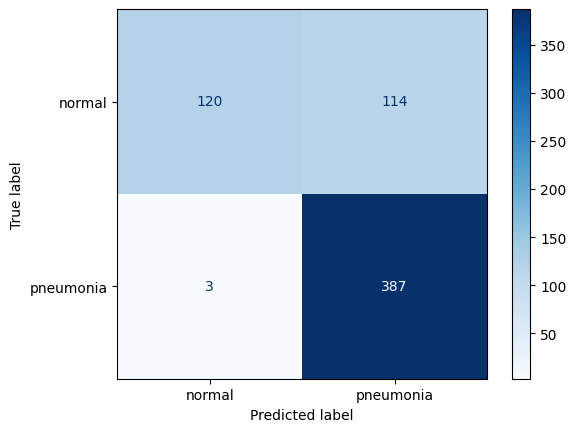

In [43]:
# --- Zadanie 5

model.eval()

correct = 0
total = 0
cm = torch.zeros((2, 2), dtype=torch.int32)  # macierz 2x2 dla dwóch klas

with torch.inference_mode():
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x) 
        preds = outputs.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        cm += torch.tensor(
            confusion_matrix(y.cpu(), preds.cpu(), labels=[0,1]),
            dtype=torch.int32
        )

accuracy = correct / total
print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")

# --- 7. Wyświetlenie macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm.numpy(),
                              display_labels=['normal','pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Zadanie 6 – Zapis modelu

Ostatnim etapem jest zapisanie słownika z parametrami modelu.
1. Zdefiniuj ścieżkę do pliku.
2. Pobierz słownik z parametrami za pomocą metody `.state_dict()`.
3. Zapisz słownik za pomocą funkcji `torch.save`.

In [44]:
# --- Zadanie 6

## Zadanie 7 – Wykonaj podobną klasyfikację dla zbioru danych OrganMNIST3D

Poniższy kod automatycznie pobiera dane.

Opis: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
Liczba klas: 11 ; klasy: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
Rozmiar obrazów: (1, 28, 28, 28)
Rozmiary: 971 161 610


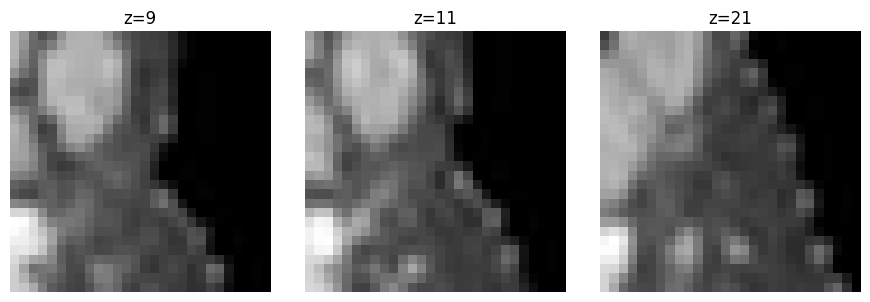

Przykładowa etykieta: 3


In [63]:
from medmnist import OrganMNIST3D, INFO

DATA_ROOT = "./data/medmnist"
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['organmnist3d']
print("Opis:", info['description'])
num_classes = len(info['label'])
print("Liczba klas:", num_classes, "; klasy:", info['label'])

# Print image shape using the first image in the train set
sample_img, _ = OrganMNIST3D(split='train', download=True, root=DATA_ROOT, as_rgb=False)[0]
print("Rozmiar obrazów:", np.array(sample_img).shape)

to_float32 = lambda x: torch.tensor(x, dtype=torch.float32) / 255.0

train_raw = OrganMNIST3D(split='train', download=True, root=DATA_ROOT, as_rgb=False, transform=to_float32)
val_raw   = OrganMNIST3D(split='val',   download=True, root=DATA_ROOT, as_rgb=False, transform=to_float32)
test_raw  = OrganMNIST3D(split='test',  download=True, root=DATA_ROOT, as_rgb=False, transform=to_float32)

print("Rozmiary:", len(train_raw), len(val_raw), len(test_raw))

# Szybki podgląd wolumenu 3D (3 losowe przekroje axial)
sample_vol, sample_y = train_raw[0]   # numpy array shape (1,28,28,28), label np.int
z_slices = sorted(random.sample(range(sample_vol.shape[-1]), 3))
fig, axes = plt.subplots(1, 3, figsize=(9,3))
for ax, z in zip(axes, z_slices):
    ax.imshow(sample_vol[0, :, :, z], cmap='gray')
    ax.set_title(f"z={z}")
    ax.axis('off')
plt.tight_layout(); plt.show()
print("Przykładowa etykieta:", int(sample_y.squeeze().item()))

## Zadanie 8 – Stwórz DataLoader dla zbioru danych OrganMNIST3D

Nie musisz pisać własnego Datasetu. Skorzystaj ze zwracanych przez funkcję `OrganMNIST3D`. Zwróć jaki teraz jest kształt danych.

In [46]:
# --- Zadanie 8

train_dataloader = DataLoader(train_raw, batch_size=8, shuffle=True)
val_dataloader   = DataLoader(val_raw, batch_size=8, shuffle=False)
test_dataloader  = DataLoader(test_raw, batch_size=8, shuffle=False)

print(train_raw)


next(iter(train_dataloader))[0].shape


Dataset OrganMNIST3D of size 28 (organmnist3d)
    Number of datapoints: 971
    Root location: ./data/medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0


torch.Size([8, 1, 28, 28, 28])

In [58]:
xb, yb = next(iter(train_dataloader))
print("Kształt X:", xb.shape)
print("Typ X:", xb.dtype)
print("Zakres wartości X:", xb.min().item(), xb.max().item())
print("Kształt y:", yb.shape, "unikalne etykiety:", yb.unique())


Kształt X: torch.Size([8, 1, 28, 28, 28])
Typ X: torch.float32
Zakres wartości X: 0.0 0.003921568859368563
Kształt y: torch.Size([8, 1]) unikalne etykiety: tensor([0, 3, 5, 7, 9])


## Zadanie 9 – Stwórz prostą sieć dla zbioru danych OrganMNIST3D

Zamiast `nn.Conv2d` wykorzystaj `nn.Conv3d`, a zamiast `nn.MaxPool2d` użyj `nn.MaxPool3d`.

In [73]:
# --- Zadanie 9

class SimpleCNN3D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(32 * 7 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,14,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32, 7, 7, 7]
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
model = SimpleCNN3D(num_classes=11).to(device)

## Zadanie 10 – Wykonaj trening sieci dla zbioru danych OrganMNIST3D

W tym przypadku może być potrzebne 20 epok.

In [75]:
# --- Zadanie 10

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters())

EPOCHS = 20

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = run_epoch(model, train_dataloader, device, loss_fn, optim)

    with torch.inference_mode():
        val_loss, val_acc = run_epoch(model, test_dataloader, device, loss_fn, None)

    print(f"Epoka [{epoch+1}/{EPOCHS}]")
    print(f"  Trening:    strata = {train_loss:.4f}, dokładność = {train_acc:.4f}")
    print(f"  Walidacja: strata = {val_loss:.4f}, dokładność = {val_acc:.4f}")

  5%|███████▊                                                                                                                                                    | 1/20 [00:01<00:22,  1.19s/it]

Epoka [1/20]
  Trening:    strata = 0.3905, dokładność = 0.8558
  Walidacja: strata = 0.7035, dokładność = 0.7410


 10%|███████████████▌                                                                                                                                            | 2/20 [00:02<00:20,  1.14s/it]

Epoka [2/20]
  Trening:    strata = 0.3614, dokładność = 0.8692
  Walidacja: strata = 0.7590, dokładność = 0.7443


 15%|███████████████████████▍                                                                                                                                    | 3/20 [00:03<00:19,  1.12s/it]

Epoka [3/20]
  Trening:    strata = 0.3380, dokładność = 0.8919
  Walidacja: strata = 0.7135, dokładność = 0.7541


 20%|███████████████████████████████▏                                                                                                                            | 4/20 [00:04<00:17,  1.12s/it]

Epoka [4/20]
  Trening:    strata = 0.3163, dokładność = 0.8877
  Walidacja: strata = 0.6327, dokładność = 0.7885


 25%|███████████████████████████████████████                                                                                                                     | 5/20 [00:05<00:16,  1.12s/it]

Epoka [5/20]
  Trening:    strata = 0.2726, dokładność = 0.9083
  Walidacja: strata = 0.6735, dokładność = 0.7803


 30%|██████████████████████████████████████████████▊                                                                                                             | 6/20 [00:06<00:15,  1.12s/it]

Epoka [6/20]
  Trening:    strata = 0.2466, dokładność = 0.9228
  Walidacja: strata = 0.7041, dokładność = 0.7672


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 7/20 [00:07<00:14,  1.11s/it]

Epoka [7/20]
  Trening:    strata = 0.2468, dokładność = 0.9145
  Walidacja: strata = 0.6380, dokładność = 0.7820


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 8/20 [00:08<00:13,  1.11s/it]

Epoka [8/20]
  Trening:    strata = 0.2097, dokładność = 0.9341
  Walidacja: strata = 0.6661, dokładność = 0.7770


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 9/20 [00:10<00:12,  1.11s/it]

Epoka [9/20]
  Trening:    strata = 0.2023, dokładność = 0.9372
  Walidacja: strata = 0.6588, dokładność = 0.7918


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 10/20 [00:11<00:11,  1.11s/it]

Epoka [10/20]
  Trening:    strata = 0.1761, dokładność = 0.9444
  Walidacja: strata = 0.6769, dokładność = 0.7918


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11/20 [00:12<00:09,  1.11s/it]

Epoka [11/20]
  Trening:    strata = 0.1623, dokładność = 0.9454
  Walidacja: strata = 0.6412, dokładność = 0.8049


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12/20 [00:13<00:08,  1.11s/it]

Epoka [12/20]
  Trening:    strata = 0.1307, dokładność = 0.9650
  Walidacja: strata = 0.6325, dokładność = 0.8164


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13/20 [00:14<00:07,  1.11s/it]

Epoka [13/20]
  Trening:    strata = 0.1659, dokładność = 0.9423
  Walidacja: strata = 0.7430, dokładność = 0.7869


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 14/20 [00:15<00:06,  1.11s/it]

Epoka [14/20]
  Trening:    strata = 0.1138, dokładność = 0.9681
  Walidacja: strata = 0.7444, dokładność = 0.7984


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 15/20 [00:16<00:05,  1.11s/it]

Epoka [15/20]
  Trening:    strata = 0.1246, dokładność = 0.9670
  Walidacja: strata = 0.6950, dokładność = 0.8148


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 16/20 [00:17<00:04,  1.11s/it]

Epoka [16/20]
  Trening:    strata = 0.0868, dokładność = 0.9773
  Walidacja: strata = 0.6921, dokładność = 0.8164


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 17/20 [00:18<00:03,  1.11s/it]

Epoka [17/20]
  Trening:    strata = 0.0739, dokładność = 0.9784
  Walidacja: strata = 0.7756, dokładność = 0.8033


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [00:20<00:02,  1.12s/it]

Epoka [18/20]
  Trening:    strata = 0.0721, dokładność = 0.9804
  Walidacja: strata = 0.7371, dokładność = 0.8180


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [00:21<00:01,  1.12s/it]

Epoka [19/20]
  Trening:    strata = 0.0580, dokładność = 0.9876
  Walidacja: strata = 0.7781, dokładność = 0.8131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.12s/it]

Epoka [20/20]
  Trening:    strata = 0.0466, dokładność = 0.9938
  Walidacja: strata = 0.7930, dokładność = 0.8148


## Zadanie 11 – Sprawdź dokładność i macierz pomyłek dla zbioru danych OrganMNIST3D

[3D] Test accuracy: 0.8148


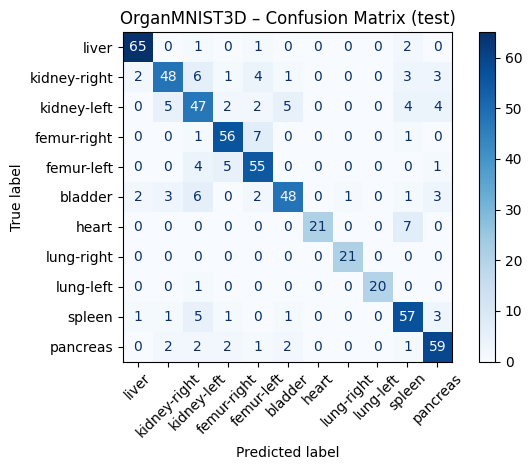

In [79]:
# --- Zadanie 11
model.eval()

correct = 0
total = 0
cm = np.zeros((num_classes, num_classes), dtype=int)

with torch.inference_mode():
    for x, y in test_dataloader:
        x = x.to(device, non_blocking=True)
        y = torch.as_tensor(y, dtype=torch.long, device=device).view(-1)

        logits = model(x)
        preds  = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total   += y.size(0)

        cm += confusion_matrix(y.cpu().numpy(),
                               preds.cpu().numpy(),
                               labels=list(range(num_classes)))

test_acc = correct / total
print(f"[3D] Test accuracy: {test_acc:.4f}")



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info['label'].values())
disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
plt.title('OrganMNIST3D – Confusion Matrix (test)')
plt.tight_layout()
plt.show()

In [78]:
info['label'].values()

dict_values(['liver', 'kidney-right', 'kidney-left', 'femur-right', 'femur-left', 'bladder', 'heart', 'lung-right', 'lung-left', 'spleen', 'pancreas'])